**IMPORTIG LIBRARIES**

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

**CREATING A DECISION TREE**

In [10]:

# Function to calculate Gini impurity
def gini_impurity(y):
    p = np.bincount(y) / len(y)
    return 1 - np.sum(p ** 2)

# Function to split the dataset based on a feature and its values
def split_data(X, y, feature_index, threshold):
    left_indices = X[:, feature_index] <= threshold
    right_indices = X[:, feature_index] > threshold
    return X[left_indices], X[right_indices], y[left_indices], y[right_indices]

# Function to find the best split
def best_split(X, y):
    best_gini = float('inf')
    best_split_info = None
    for feature_index in range(X.shape[1]):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            X_left, X_right, y_left, y_right = split_data(X, y, feature_index, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue
            gini_left = gini_impurity(y_left)
            gini_right = gini_impurity(y_right)
            weighted_gini = (len(y_left) * gini_left + len(y_right) * gini_right) / len(y)
            if weighted_gini < best_gini:
                best_gini = weighted_gini
                best_split_info = (feature_index, threshold)
    return best_split_info

# Class for building the decision tree
class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]
        predicted_class = np.argmax(num_samples_per_class)

        # Stop conditions
        if len(np.unique(y)) == 1 or depth >= self.max_depth or len(y) < self.min_samples_split:
            return predicted_class

        feature_index, threshold = best_split(X, y)
        if feature_index is None:
            return predicted_class

        X_left, X_right, y_left, y_right = split_data(X, y, feature_index, threshold)

        left_branch = self._build_tree(X_left, y_left, depth + 1)
        right_branch = self._build_tree(X_right, y_right, depth + 1)
        return (feature_index, threshold, left_branch, right_branch)

    def predict(self, X):
        return np.array([self._predict_input(x, self.tree) for x in X])

    def _predict_input(self, x, tree):
      if isinstance(tree, (int, np.integer)):  # Check if it's a leaf node (class label)
          return tree
      feature_index, threshold, left_branch, right_branch = tree
      if x[feature_index] <= threshold:
          return self._predict_input(x, left_branch)
      else:
          return self._predict_input(x, right_branch)


In [12]:
data = pd.read_csv('/content/Breast_Cancer.csv')
data.info() # gives count of non null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

In [13]:
data.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


In [14]:
print(data.columns) # columns in the dataset

Index(['Age', 'Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage',
       'differentiate', 'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')


FEATURE ENCODING

In [15]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

one_hot_columns = ['Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage', 'A Stage',
                   'Estrogen Status', 'Progesterone Status']

# Apply one-hot encoding
data = pd.get_dummies(data, columns=one_hot_columns, drop_first=True)

# Apply label encoding for ordinal variables
label_columns = ['differentiate', 'Grade']
for col in label_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Standardization on numeric features
numeric_columns = ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months']
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Encoding target variable
data['Status'] = data['Status'].apply(lambda x: 1 if x == 'Dead' else 0)

# Split features and target
X = data.drop('Status', axis=1).values
y = data['Status'].values

stadardised dataset

In [16]:
data.head()

,Age,differentiate,Grade,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months,Status,Race_Other,Race_White,...,T Stage _T4,N Stage_N2,N Stage_N3,6th Stage_IIB,6th Stage_IIIA,6th Stage_IIIB,6th Stage_IIIC,A Stage_Regional,Estrogen Status_Positive,Progesterone Status_Positive
0,1.565253,1,3,-1.253661,1.190676,-0.618172,-0.492961,0,False,True,...,False,False,False,False,False,False,False,True,True,True
1,-0.443222,0,2,0.214345,-0.044095,0.164807,-0.405695,0,False,True,...,False,True,False,False,True,False,False,True,True,True
2,0.449434,0,2,1.540287,-0.044095,0.556296,0.161530,0,False,True,...,False,False,True,False,False,False,True,True,True,True
3,0.449434,1,3,-0.590691,-1.525820,-0.618172,0.554224,0,False,True,...,False,False,False,False,False,False,False,True,True,True
4,-0.777968,1,3,0.498475,-1.402343,-0.618172,-0.929288,0,False,True,...,False,False,False,True,False,False,False,True,True,True


Train Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Training of decision tree

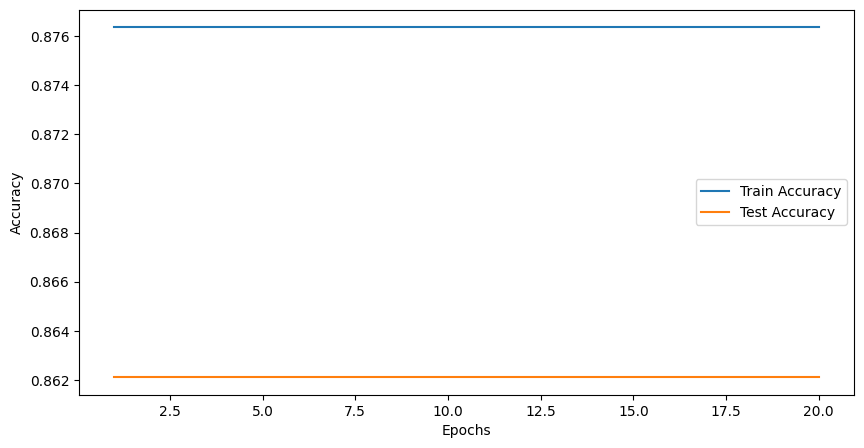

In [30]:
tree = DecisionTree(max_depth=6, min_samples_split=30)

# Store accuracy and loss
train_accuracies = []
test_accuracies = []
epochs = 20

for epoch in range(1, epochs + 1):
    tree.fit(X_train, y_train)

    # Predict on train and validation data
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)

    train_accuracy = np.mean(y_train_pred == y_train)
    test_accuracy = np.mean(y_test_pred == y_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<h1>Inference <h1/>

1. The Desion Tree was fit in the successfully and we got a training accuracy of 0.876 and validation accuracy of 0.862.
2. The number of epoch did not matter as the algorithm always makes the single best tree possible
3. The best values of max_depth and min_samples_split was determined by experimenting, using the maximum value of accuracy and minimum difference between train accuracy and test accuracy (tradeoff betwee overfitting and uderfitting)

GENERATED A CODE FOR GENERATING A RANDOM SET OF INPUT FEATURES, FOR GIVING PREDICTIONS

In [51]:
# prompt: generate a set of features similar to the coloumns of the encoded and standardised dataset above, for making predictions using the decision tree

# Assuming you have the original dataset loaded as 'data' and the encoded/standardized dataset as 'data_encoded'
# Get the column names from the encoded/standardized dataset
feature_names = data.columns.tolist()

# Remove the target variable (if it's included)
if 'Status' in feature_names:
    feature_names.remove('Status')

# Create a new dataframe with the same features and fill with random or example values
new_data = pd.DataFrame(columns=feature_names)

# Example: Fill with random values within a reasonable range for each feature
for col in feature_names:
    if col in ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months']:
        new_data[col] = np.random.uniform(-2, 2, size=1)  # Using a range similar to standardized data
    else:
        new_data[col] = np.random.randint(0, 2, size=1)  # For binary or one-hot encoded features

# You can modify the code to provide specific example values instead of random ones
# For example: new_data['Age'] = [50]

print( new_data)
# Convert the dataframe to a NumPy array
new_features = new_data.values

# Predict the status using the trained decision tree
prediction = tree.predict(new_features)

print(f"Predicted Status: {prediction[0]}") # 1 for Dead, 0 for Alive


        Age  differentiate  Grade  Tumor Size  Regional Node Examined  \
0  1.198387              0      1    0.954223               -0.694138   

   Reginol Node Positive  Survival Months  Race_Other  Race_White  \
0              -0.237549         0.481115           1           1   

   Marital Status_Married  ...  T Stage _T4  N Stage_N2  N Stage_N3  \
0                       1  ...            1           1           0   

   6th Stage_IIB  6th Stage_IIIA  6th Stage_IIIB  6th Stage_IIIC  \
0              1               0               1               1   

   A Stage_Regional  Estrogen Status_Positive  Progesterone Status_Positive  
0                 0                         0                             0  

[1 rows x 25 columns]
Predicted Status: 0
